<a href="https://colab.research.google.com/github/YIFANK/6.7960/blob/main/6_7960_Fall_2025_hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from typing import Tuple, Union, Optional, List
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [2]:

# a utility for calculating running average
class AverageMeter():
    def __init__(self):
        self.num = 0
        self.tot = 0

    def update(self, val: float, sz: float):
        self.num += val*sz
        self.tot += sz

    def calculate(self) -> float:
        return self.num/self.tot

# Problem 1: Dialogue GPT

In [3]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=0cd24b8e39245bdf10141422581c69725577ce0a826a2e1a7502b678fb27b3e4
  Stored in directory: /root/.cache/pip/wheels/01/46/3b/e29ffbe4ebe614ff224bad40fc6a5773a67a163251585a13a9
Successfully built wget


In [4]:
import wget
import os
if not os.path.exists("input.txt"):
    wget.download("https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt")

In [5]:
with open('input.txt', 'r') as f:
    raw_text = f.read()
all_dialogues = raw_text.split('\n\n')


In [6]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Part 1.A

In [36]:
def tokenize(s):
  return word_tokenize(s)

class MyTokenizer:
    def __init__(self, raw_text: str):
        # raw_text     contains the text from which we will build our vocabulary

        self.start = '<START>' # token that starts every example
        self.pad = '<PAD>' # token used to pad examples to the same length
        self.unk = '<UNK>' # token used if encountering a word not in our vocabulary

        vocab = np.unique(tokenize(raw_text))
        vocab = np.concatenate([np.array([self.start, self.pad, self.unk]), vocab])

        self.vocab = vocab # array of tokens in order
        self.tok_to_id = {w: i for i, w in enumerate(vocab)} # mapping of token to ID
        self.vocab_size = len(self.vocab) # size of vocabulary

    def encode(self, s: str) -> torch.Tensor:
        # s           input string
        #
        # Output
        # id_tensor   a tensor of token ids, starting with the start token.t

        id_tensor = None

        # TODO: tokenize the input using word_tokenize. Return a tensor
        # of the token ids, starting with the token id for the start token.
        # ============ ANSWER START ===========
        words = tokenize(s)
        id_list = []
        for w in words:
          if w not in self.tok_to_id:
            id_list.append(self.unk)
          else:
            id_list.append(w)
        id_tensor = torch.tensor([self.tok_to_id[w] for w in id_list],dtype = torch.long)
        id_tensor = torch.cat([torch.tensor([self.tok_to_id[self.start]]), id_tensor])
        # ============ ANSWER END =============

        return id_tensor

    def decode(self, toks: torch.Tensor) -> str:
        # toks         a list of token ids
        #
        # Output
        # decoded_str  the token ids decoded back into a string (join with a space)

        decoded_str = None

        # TODO: convert the token ids back to the actual corresponding words.
        # Join the tokens with a space and return the full string
        # ============ ANSWER START ===========
        decoded_str = ' '.join([self.vocab[t] for t in toks])
        # ============ ANSWER END =============

        return decoded_str

    def pad_examples(self, tok_list: List[torch.Tensor]) -> torch.Tensor:
        # Pads the tensors to the right with the pad token so that they are the same length.
        #
        # tok_list       a list of tensors containing token ids (maybe of different lengths)
        #
        # Output
        # padded_tokens  shape: (len(tok_list), max length within tok_list)
        return torch.nn.utils.rnn.pad_sequence(tok_list, batch_first=True, padding_value=self.tok_to_id[self.pad])

tok = MyTokenizer(raw_text)

In [29]:
# tokenizer test cases
input_string = 'KING RICHARD III:\nSay that I did all this for love of her.'
enc = tok.encode(input_string)
print(enc)
dec = tok.decode(enc)
print(dec)
assert dec == "<START> KING RICHARD III : Say that I did all this for love of her ."

tensor([    0,  1593,  2182,  1481,   223,  2343, 12742,  1476,  5704,  3319,
        12795,  6848,  8727,  9608,  7655,   221])
<START> KING RICHARD III : Say that I did all this for love of her .


## Part 1.B

In [37]:
class DialogueDataset:
    def __init__(self, tokenizer: MyTokenizer, lines: List[str], max_N: int):
        # tokenizer    an instance of MyTokenizer
        # lines        a list of strings. each element in an example in the dataset
        # max_N        the maximum number of tokens allowed per example. More than this will be truncated
        self.lines = lines
        self.tokenizer = tokenizer
        self.max_N = max_N

    def __len__(self) -> int:
        return len(self.lines)

    def __getitem__(self, idx: int) -> torch.Tensor:
        # returns the example at int encoded by the tokenizer
        # truncates the example if it is more than max_N tokens
        return self.tokenizer.encode(self.lines[idx])[:self.max_N]

def collate_fn(examples: List[torch.Tensor]):
    # examples        a batch of tensors containing token ids (maybe of different lengths)
    # Outputs a dictionary containing
    #   input_ids     a single tensor with all of the examples padded (from the right) to the max
    #                 length within the batch. shape:(B, max length within examples)
    #   input_mask    a tensor indicating which tokens are padding and should be ignored. 0 if padding
    #                 and 1 if not. shape: (B, max length within examples)
    new_input_ids = tok.pad_examples(examples)
    attn_mask = torch.ones(new_input_ids.shape)
    attn_mask[new_input_ids == tok.tok_to_id[tok.pad]] = 0
    return {'input_ids': tok.pad_examples(examples), 'input_mask': attn_mask}

ds = DialogueDataset(tok, all_dialogues, max_N=200)
training_dl = torch.utils.data.DataLoader(ds, batch_size=64, collate_fn=collate_fn)

In [38]:
# take a look at an example of an element from the training dataloader
for batch in training_dl:
    print(batch)
    break

{'input_ids': tensor([[   0, 1151,  708,  ...,    1,    1,    1],
        [   0,  323,  223,  ...,    1,    1,    1],
        [   0, 1151,  708,  ...,    1,    1,    1],
        ...,
        [   0, 1733,  223,  ...,    1,    1,    1],
        [   0, 1151, 2385,  ...,    1,    1,    1],
        [   0, 1733,  223,  ...,    1,    1,    1]]), 'input_mask': tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])}


## Part 1.C

In [39]:
class DialogueGPT(nn.Module):
    def __init__(self, vocab_size: int, max_N: int, dim: int, mlp_dim: int, num_heads: int, num_layers: int):
        # vocab_size       size of the vocabulary
        # max_N            maximum number of tokens allowed to appear in 1 example
        # dim              embedding dimension
        # mlp_dim          the hidden layer dimension of the FFN
        # num_heads        the number of heads in the attention layer
        # num_layers       the number of attention layers.

        super().__init__()

        # TODO: set up the token embedding and positional embeddings
        #       Hint, use nn.Embedding
        # ============ ANSWER START ============
        self.token_emb = nn.Embedding(vocab_size, dim)
        self.pos_emb = nn.Embedding(max_N, dim)
        # ============ ANSWER END ==============

        # NOTE: Even though we use a TransformerEncoder, applying a causal attention mask makes it behavior like a GPT-style decoder.
        transformer_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=num_heads, dim_feedforward=mlp_dim, batch_first=True)
        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)


        self.head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, vocab_size)
        )

    def forward(self, input_ids: torch.Tensor) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        # input_ids     a batch of input ids (right padded). shape: (B x T)
        #
        # Output
        # out           the logit vector (B x T x V)
        # alphas        the attention weights if return_attn is True. Otherwise None shape: (B, num_layers, num_heads, T, T)

        embs = None

        # TODO: retrieve the token embeddings for the input_ids.
        #       Add to the token embeddings the positional embeddings.
        #       Store the combined embedding in embs
        # ============ ANSWER START ============
        device = input_ids.device
        B, T = input_ids.shape
        pos_ids = torch.arange(T, device=device)
        embs = self.token_emb(input_ids) + self.pos_emb(pos_ids)
        # ============ ANSWER END ============

        causal_attn_mask = None

        # TODO: Create the causal attention mask, which should be a boolean tensor of size (T, T).
        #       Remember that the causal attention mask is lower triangular (all tokens only
        #       depend on themselves and the tokens before them).
        #       In PyTorch's TransformerEncoder, True indicates positions to ignore, so you need to invert the mask.
        #       Store the mask in causal_attn_mask
        # Hint: check out torch.tril
        # ============ ANSWER START ============
        causal_attn_mask = torch.tril(torch.ones(input_ids.shape[1], input_ids.shape[1])).bool()
        causal_attn_mask = causal_attn_mask.to(device)
        # ============ ANSWER END ==============

        x = self.transformer(embs, mask=causal_attn_mask)
        out = self.head(x)
        return out

    def generate(self, input_ids, num_tokens):
        # you can assume batch size 1
        with torch.no_grad():
            for i in range(num_tokens):
                out = self.forward(input_ids)
                new_token = torch.argmax(out[:, [-1]], -1)
                input_ids = torch.cat([input_ids, new_token], dim=1)
        return input_ids

## Part 1.D

In [40]:

class DialogueLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.criterion = nn.CrossEntropyLoss(reduction='none')

    def forward(self, logits: torch.Tensor, input_ids: torch.Tensor, inp_mask: torch.Tensor):
        # logits      the logits produced by DialogueGPT. shape: (B x T x V)
        # input_ids   the token ids. shape: (B x T)
        # inp_mask    a 0/1 mask of which tokens are padding tokens and should be ignored. shape: (B x T)

        # TODO: Implement the language model loss. For logits[i], we want to supervise the i+1 token_id
        # with the cross entropy loss. We thus will not supervise the start token (input_ids[0]) or use
        # the last logit vector (logits[-1]). Return the average of the losses for each token in the batch,
        # making sure to ignore tokens corresponding to the padding (use inp_mask).

        # ============ ANSWER START ============
        shift_logits = logits[:, :-1].contiguous()
        shift_labels = input_ids[:, 1:].contiguous()
        shift_mask = inp_mask[:, 1:].contiguous()
        loss = self.criterion(shift_logits.view(-1, shift_logits.shape[-1]), shift_labels.view(-1))
        loss = (loss * shift_mask.view(-1))
        loss = loss.sum() / shift_mask.sum()
        return loss
        # ============ ANSWER END ==============


## Part 1.F

In [41]:
import torch.optim as optim

model = DialogueGPT(vocab_size=tok.vocab_size, max_N=200, dim=128, mlp_dim=128, num_heads=4, num_layers=6).cuda()
criterion = DialogueLoss()

NUM_EPOCHS = 80



optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)


In [42]:
# Time estimate: around 30 minutes on T4 GPU
# Training
import tqdm
for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
    loss_meter = AverageMeter()
    for inp_dict in tqdm.tqdm(training_dl):
        # get the inputs; data is a list of [inputs, labels]
        inp_ids, inp_mask = inp_dict['input_ids'], inp_dict['input_mask']
        inp_ids = inp_ids.cuda()
        inp_mask = inp_mask.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(input_ids=inp_ids)
        loss = criterion(outputs, inp_ids, inp_mask)
        loss_meter.update(loss.item(), len(inp_dict['input_ids']))
        loss.backward()
        optimizer.step()
    scheduler.step()

        # print example
    inp = tok.encode("").unsqueeze(0).cuda()
    print(tok.decode(model.generate(inp, 10)[0].cpu()))

    print(f"Train Epoch: {epoch}, Loss: {loss_meter.calculate():0.4f}, LR: {scheduler.get_last_lr()[0]}")


100%|██████████| 113/113 [00:15<00:00,  7.32it/s]


<START> moved , amort your ! PRINCE come , ! !
Train Epoch: 0, Loss: 8.6146, LR: 9.996145181203615e-05


100%|██████████| 113/113 [00:15<00:00,  7.33it/s]


<START> for : , , , , , . , ,
Train Epoch: 1, Loss: 7.2509, LR: 9.98458666866564e-05


100%|██████████| 113/113 [00:15<00:00,  7.47it/s]


<START> for : I , , the , : , ,
Train Epoch: 2, Loss: 6.6526, LR: 9.965342284774632e-05


100%|██████████| 113/113 [00:15<00:00,  7.51it/s]


<START> 'd : I , but , in : to to
Train Epoch: 3, Loss: 6.4725, LR: 9.938441702975689e-05


100%|██████████| 113/113 [00:15<00:00,  7.51it/s]


<START> KING : I , and , and . , but
Train Epoch: 4, Loss: 6.3191, LR: 9.903926402016153e-05


100%|██████████| 113/113 [00:15<00:00,  7.44it/s]


<START> KING : I : I the , I : I
Train Epoch: 5, Loss: 6.1179, LR: 9.861849601988383e-05


100%|██████████| 113/113 [00:15<00:00,  7.44it/s]


<START> KING : What , and , and ? , and
Train Epoch: 6, Loss: 5.9279, LR: 9.812276182268236e-05


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> KING : What , and me , and me ,
Train Epoch: 7, Loss: 5.7067, LR: 9.755282581475769e-05


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> KING : What , but a the your me ,
Train Epoch: 8, Loss: 5.4391, LR: 9.690956679612421e-05


100%|██████████| 113/113 [00:15<00:00,  7.46it/s]


<START> KING : What , And , and ? , And
Train Epoch: 9, Loss: 5.1460, LR: 9.619397662556433e-05


100%|██████████| 113/113 [00:15<00:00,  7.46it/s]


<START> KING : What , sir , but a the ,
Train Epoch: 10, Loss: 4.8637, LR: 9.540715869125406e-05


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> First : What , sir , sir more to me
Train Epoch: 11, Loss: 4.6051, LR: 9.455032620941839e-05


100%|██████████| 113/113 [00:15<00:00,  7.43it/s]


<START> First : What , sir , But 's , But
Train Epoch: 12, Loss: 4.3648, LR: 9.362480035363986e-05


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> KING : What , sir , sir my me ,
Train Epoch: 13, Loss: 4.1363, LR: 9.263200821770461e-05


100%|██████████| 113/113 [00:15<00:00,  7.46it/s]


<START> First : What , That thy , sir , But
Train Epoch: 14, Loss: 3.9204, LR: 9.157348061512727e-05


100%|██████████| 113/113 [00:15<00:00,  7.46it/s]


<START> KING : What , sir , But he him .
Train Epoch: 15, Loss: 3.7161, LR: 9.045084971874738e-05


100%|██████████| 113/113 [00:15<00:00,  7.46it/s]


<START> KING : What , sir , But that all !
Train Epoch: 16, Loss: 3.5263, LR: 8.926584654403724e-05


100%|██████████| 113/113 [00:15<00:00,  7.47it/s]


<START> KING : What , That thy would my heart But
Train Epoch: 17, Loss: 3.3481, LR: 8.802029828000156e-05


100%|██████████| 113/113 [00:15<00:00,  7.46it/s]


<START> KING : What 'll , But as he had at
Train Epoch: 18, Loss: 3.1792, LR: 8.671612547178429e-05


100%|██████████| 113/113 [00:15<00:00,  7.46it/s]


<START> KING : What 'll to come as he had are
Train Epoch: 19, Loss: 3.0221, LR: 8.535533905932738e-05


100%|██████████| 113/113 [00:15<00:00,  7.46it/s]


<START> KING : But must then ? If of mine own
Train Epoch: 20, Loss: 2.8781, LR: 8.39400372766471e-05


100%|██████████| 113/113 [00:15<00:00,  7.46it/s]


<START> ISABELLA : But must then will , Which thou art
Train Epoch: 21, Loss: 2.7420, LR: 8.247240241650919e-05


100%|██████████| 113/113 [00:15<00:00,  7.44it/s]


<START> First : If not hath but what have all '
Train Epoch: 22, Loss: 2.6195, LR: 8.095469746549169e-05


100%|██████████| 113/113 [00:15<00:00,  7.43it/s]


<START> ISABELLA : If not then ? By if me ,
Train Epoch: 23, Loss: 2.5014, LR: 7.938926261462365e-05


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> SICINIUS : If this most thou art You all '
Train Epoch: 24, Loss: 2.3918, LR: 7.77785116509801e-05


100%|██████████| 113/113 [00:15<00:00,  7.46it/s]


<START> TRANIO : Nay , Which thou art You , But
Train Epoch: 25, Loss: 2.2909, LR: 7.612492823579744e-05


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> KING : If heart That thy head -- ' again
Train Epoch: 26, Loss: 2.1978, LR: 7.443106207484775e-05


100%|██████████| 113/113 [00:15<00:00,  7.44it/s]


<START> KING : If not hath but old my heart make
Train Epoch: 27, Loss: 2.1110, LR: 7.269952498697733e-05


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> ROMEO : Here eyes as there , Not should make
Train Epoch: 28, Loss: 2.0304, LR: 7.093298687687139e-05


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> ISABELLA : If head dear said make my heart We
Train Epoch: 29, Loss: 1.9541, LR: 6.913417161825447e-05


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> SICINIUS : If not hath but old my brother come
Train Epoch: 30, Loss: 1.8856, LR: 6.730585285387463e-05


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> SICINIUS : If not then ? If As thou art
Train Epoch: 31, Loss: 1.8187, LR: 6.545084971874736e-05


100%|██████████| 113/113 [00:15<00:00,  7.46it/s]


<START> TRANIO : If Were prince All ? Nay , Yet
Train Epoch: 32, Loss: 1.7579, LR: 6.35720224932537e-05


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> ROMEO : If heart My , Which thou mine own
Train Epoch: 33, Loss: 1.7012, LR: 6.167226819279526e-05


100%|██████████| 113/113 [00:15<00:00,  7.43it/s]


<START> ROMEO : If Were makes thy men my heart We
Train Epoch: 34, Loss: 1.6465, LR: 5.97545161008064e-05


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> TRANIO : If little prince All ? You had be
Train Epoch: 35, Loss: 1.5978, LR: 5.782172325201153e-05


100%|██████████| 113/113 [00:15<00:00,  7.46it/s]


<START> ROMEO : If Were forth believe long To make now
Train Epoch: 36, Loss: 1.5511, LR: 5.587686987289187e-05


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> COMINIUS : If Were night made better two IV king
Train Epoch: 37, Loss: 1.5077, LR: 5.392295478639223e-05


100%|██████████| 113/113 [00:15<00:00,  7.44it/s]


<START> COMINIUS : If Were night she news , Then eyes
Train Epoch: 38, Loss: 1.4665, LR: 5.196299078795341e-05


100%|██████████| 113/113 [00:15<00:00,  7.44it/s]


<START> COMINIUS : If Were child know Where I pray eyes
Train Epoch: 39, Loss: 1.4285, LR: 4.999999999999998e-05


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> COMINIUS : If honour My , Which thou hast again
Train Epoch: 40, Loss: 1.3936, LR: 4.8037009212046566e-05


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> SICINIUS Is Why , Which thou art thou hast eyes
Train Epoch: 41, Loss: 1.3601, LR: 4.6077045213607746e-05


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> TRANIO : If Were night she oath hast heart We
Train Epoch: 42, Loss: 1.3277, LR: 4.4123130127108115e-05


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> TRANIO : If Were night she comes true eyes made
Train Epoch: 43, Loss: 1.2995, LR: 4.217827674798846e-05


100%|██████████| 113/113 [00:15<00:00,  7.44it/s]


<START> BIONDELLO : If Were night she report themselves old things
Train Epoch: 44, Loss: 1.2725, LR: 4.024548389919358e-05


100%|██████████| 113/113 [00:15<00:00,  7.44it/s]


<START> BIONDELLO : If Were night she children old bed eyes
Train Epoch: 45, Loss: 1.2467, LR: 3.832773180720473e-05


100%|██████████| 113/113 [00:15<00:00,  7.44it/s]


<START> TRANIO : If friends comes made born my troth out
Train Epoch: 46, Loss: 1.2234, LR: 3.642797750674627e-05


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> COMINIUS : If Were night she report o'er him are
Train Epoch: 47, Loss: 1.2017, LR: 3.454915028125263e-05


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> COMINIUS : Away My told do better two IV are
Train Epoch: 48, Loss: 1.1808, LR: 3.269414714612536e-05


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> PAULINA : Away fair hate since oath hast heart eyes
Train Epoch: 49, Loss: 1.1597, LR: 3.086582838174551e-05


100%|██████████| 113/113 [00:15<00:00,  7.44it/s]


<START> COMINIUS : If Were forth believe comes true eyes made
Train Epoch: 50, Loss: 1.1418, LR: 2.9067013123128613e-05


100%|██████████| 113/113 [00:15<00:00,  7.46it/s]


<START> COMINIUS : If dear thank prince , Not give report
Train Epoch: 51, Loss: 1.1269, LR: 2.7300475013022666e-05


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> COMINIUS : Nay , Which she oath hast return eyes
Train Epoch: 52, Loss: 1.1102, LR: 2.556893792515225e-05


100%|██████████| 113/113 [00:15<00:00,  7.44it/s]


<START> ROMEO : If Were despair grave death As All So
Train Epoch: 53, Loss: 1.0948, LR: 2.3875071764202563e-05


100%|██████████| 113/113 [00:15<00:00,  7.43it/s]


<START> TRANIO : If Were night left late of night since
Train Epoch: 54, Loss: 1.0825, LR: 2.222148834901989e-05


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> TRANIO : If Were forth believe even by had be
Train Epoch: 55, Loss: 1.0703, LR: 2.0610737385376352e-05


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> COMINIUS : If Were night she oath hast kings Go
Train Epoch: 56, Loss: 1.0597, LR: 1.9045302534508318e-05


100%|██████████| 113/113 [00:15<00:00,  7.44it/s]


<START> TRANIO : If Were night she frown thou hast again
Train Epoch: 57, Loss: 1.0481, LR: 1.7527597583490826e-05


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> COMINIUS : If Were night she oath hast off purpose
Train Epoch: 58, Loss: 1.0391, LR: 1.6059962723352925e-05


100%|██████████| 113/113 [00:15<00:00,  7.44it/s]


<START> COMINIUS : If Were Tower had prison he had heavens
Train Epoch: 59, Loss: 1.0303, LR: 1.4644660940672629e-05


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> PAULINA : If Were night she loves from the Tower
Train Epoch: 60, Loss: 1.0237, LR: 1.3283874528215718e-05


100%|██████████| 113/113 [00:15<00:00,  7.44it/s]


<START> ROMEO : If black comes Marcius late of RICHARD III
Train Epoch: 61, Loss: 1.0158, LR: 1.1979701719998453e-05


100%|██████████| 113/113 [00:15<00:00,  7.46it/s]


<START> ROMEO : If Were Tower had crown thee duke All
Train Epoch: 62, Loss: 1.0089, LR: 1.0734153455962748e-05


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> Pedant : If Were prince All tender only , See
Train Epoch: 63, Loss: 1.0030, LR: 9.549150281252633e-06


100%|██████████| 113/113 [00:15<00:00,  7.44it/s]


<START> COMINIUS : If Were Tower had prison he had since
Train Epoch: 64, Loss: 0.9985, LR: 8.426519384872749e-06


100%|██████████| 113/113 [00:15<00:00,  7.43it/s]


<START> AUFIDIUS : If Were Tower had such you would eyes
Train Epoch: 65, Loss: 0.9931, LR: 7.3679917822953905e-06


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> COMINIUS : If Were forth believe even in RICHARD II
Train Epoch: 66, Loss: 0.9893, LR: 6.375199646360152e-06


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> COMINIUS : If died within known men I pray eyes
Train Epoch: 67, Loss: 0.9851, LR: 5.44967379058161e-06


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> PAULINA : If Were Tower only late of York wrong
Train Epoch: 68, Loss: 0.9847, LR: 4.592841308745932e-06


100%|██████████| 113/113 [00:15<00:00,  7.46it/s]


<START> ROMEO : If little prince All tender I pray own
Train Epoch: 69, Loss: 0.9809, LR: 3.806023374435663e-06


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> Pedant : If Were Tower only late of night since
Train Epoch: 70, Loss: 0.9787, LR: 3.0904332038757918e-06


100%|██████████| 113/113 [00:15<00:00,  7.44it/s]


<START> COMINIUS : If Were despair foul but old bed almost
Train Epoch: 71, Loss: 0.9764, LR: 2.447174185242323e-06


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> BENVOLIO : If Were makes , Which two IV less
Train Epoch: 72, Loss: 0.9756, LR: 1.8772381773176413e-06


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> COMINIUS : If Were night she thine -- why hate
Train Epoch: 73, Loss: 0.9733, LR: 1.381503980116172e-06


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> ROMEO : If Were Tower had such gracious friends eyes
Train Epoch: 74, Loss: 0.9713, LR: 9.607359798384783e-07


100%|██████████| 113/113 [00:15<00:00,  7.46it/s]


<START> COMINIUS : If Were Tower only late of mine king
Train Epoch: 75, Loss: 0.9732, LR: 6.155829702431169e-07


100%|██████████| 113/113 [00:15<00:00,  7.46it/s]


<START> COMINIUS : If Bianca Yet fill art You , Unless
Train Epoch: 76, Loss: 0.9712, LR: 3.4657715225368527e-07


100%|██████████| 113/113 [00:15<00:00,  7.45it/s]


<START> ROMEO : If Were Tower only Which thou wilt since
Train Epoch: 77, Loss: 0.9717, LR: 1.5413331334360177e-07


100%|██████████| 113/113 [00:15<00:00,  7.44it/s]


<START> COMINIUS : Alas Hold swear myself enemy You , Unless
Train Epoch: 78, Loss: 0.9708, LR: 3.854818796385494e-08


100%|██████████| 113/113 [00:15<00:00,  7.44it/s]

<START> COMINIUS : If bed report ? If As power eyes
Train Epoch: 79, Loss: 0.9704, LR: 0.0


## Part 1.G

In [43]:
inp = tok.encode("").unsqueeze(0).cuda()
print(tok.decode(model.generate(inp, 50)[0].cpu()))

<START> COMINIUS : Nay , Which she frown thou hast seen , ay life prove My , Whose Right , Being ne'er Ah please most Pedant neither now came against And many than mine KING HENRY VI enough should I 'll of mine own art than ; She ready All 'T


# Problem 2: What's inside a model?

## Setup

### Set seed for reproducibility

In [44]:
import os, random, numpy as np, torch

SEED = 7960  # Do not change

os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Torch determinism switches
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
try:
    torch.use_deterministic_algorithms(True, warn_only=True)
except Exception:
    pass

print("Determinism set with SEED =", SEED)


Determinism set with SEED = 7960


### Model setup (pretrained ResNet-50)

We will use a pretrained **ResNet-50** (trained on ImageNet). We’ll also set up ImageNet normalization utilities for feature synthesis and define a helper to count parameters.


In [45]:
import torch.nn as nn
from torchvision import models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Pretrained ResNet-50
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2).to(device).eval()

# ImageNet normalization for feature synthesis
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406], device=device)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225], device=device)

def count_params(m: nn.Module):
    return sum(p.numel() for p in m.parameters())

print(resnet)
print(f"\nTotal params: {count_params(resnet):,}")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 207MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [46]:
# Utilities to find layers and fetch modules by dotted path
def get_layer_by_name(model: nn.Module, dotted: str) -> nn.Module:
    m = model
    for part in dotted.replace('[', '.').replace(']', '').split('.'):
        if part.isdigit():
            m = m[int(part)]
        else:
            m = getattr(m, part)
    return m

conv_layers = []
for name, m in resnet.named_modules():
    if isinstance(m, nn.Conv2d):
        conv_layers.append((name, m.out_channels))
print(f"Found {len(conv_layers)} conv layers.")
for name, C in conv_layers[:10]:
    print(f"{name:25s} -> C={C}")
print("...")
print(f"Last layer: {conv_layers[-1][0]} -> C={conv_layers[-1][1]}")


Found 53 conv layers.
conv1                     -> C=64
layer1.0.conv1            -> C=64
layer1.0.conv2            -> C=64
layer1.0.conv3            -> C=256
layer1.0.downsample.0     -> C=256
layer1.1.conv1            -> C=64
layer1.1.conv2            -> C=64
layer1.1.conv3            -> C=256
layer1.2.conv1            -> C=64
layer1.2.conv2            -> C=64
...
Last layer: layer4.2.conv3 -> C=2048


In [47]:
import torch.nn.functional as F

class ActivationHook:
    def __init__(self, layer: nn.Module):
        self.h = layer.register_forward_hook(self._hook)
        self.act = None
    def _hook(self, m, i, o): self.act = o
    def close(self): self.h.remove()

sample_layers = ["conv1", "layer2.1.conv2", "layer4.2.conv3"]
hooks = []
for L in sample_layers:
    hooks.append((L, ActivationHook(get_layer_by_name(resnet, L))))

with torch.no_grad():
    dummy = torch.zeros(1,3,224,224, device=device)
    _ = resnet(dummy)

for L, hk in hooks:
    print(f"{L:18s} -> {tuple(hk.act.shape)}")
    hk.close()


conv1              -> (1, 64, 112, 112)
layer2.1.conv2     -> (1, 128, 28, 28)
layer4.2.conv3     -> (1, 2048, 7, 7)


In [48]:
import numpy as np

def activation_channels(model, layer_name: str, H: int = 224) -> int:
    L = get_layer_by_name(model, layer_name)
    hk = ActivationHook(L)
    with torch.no_grad():
        _ = model(torch.zeros(1,3,H,H, device=device))
        C = hk.act.shape[1]
    hk.close()
    return C

def evenly_spaced_channels(C: int, k: int = 5):
    idx = np.linspace(0, C-1, num=min(k, C), dtype=int).tolist()
    return sorted(set(int(i) for i in idx))

@torch.no_grad()
def topk_active_channels(model, layer_name: str, images: torch.Tensor, k: int = 5):
    """images: (B,3,H,W) already normalized to ImageNet stats."""
    L = get_layer_by_name(model, layer_name)
    hk = ActivationHook(L)
    _ = model(images.to(device))
    # mean over (B,H,W) to score channels
    score = hk.act.mean(dim=(0,2,3))
    hk.close()
    topk = torch.topk(score, k=min(k, score.numel()))[1].tolist()
    return sorted(topk)


## Problem 2(a): Feature visualizations across layers


### Feature Representation Synthesis

Given a (layer, channel), we synthesize an image \(x\) that maximizes the **mean activation** of that channel while using L1/L2 penalties:

$$
x^* \;=\; \underset{x}{\operatorname*{arg\,max}} \;
\mathbb{E}_{u,v}\!\left[a_{\ell,c}(x)_{u,v}\right]
\;-\; \lambda_2 \,\lVert x\rVert_2^2
\;-\; \lambda_1 \,\lVert x\rVert_1
\;-\; \lambda_{\nabla} \,\lVert \nabla x \rVert_2^2.
$$

- $\lVert x \rVert_2^2$: keeps pixel energy bounded (L2 “weight decay” on the input).
- $\lVert x \rVert_1$: encourages sparsity (fewer, stronger strokes).
- $\lVert \nabla x \rVert_2^2$: smoothness via L2 on image gradients.



In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def denorm(x):
    return (x * IMAGENET_STD.view(1,3,1,1) + IMAGENET_MEAN.view(1,3,1,1)).clamp(0,1)

def grad_l2_loss(x: torch.Tensor, weight: float = 1.0) -> torch.Tensor:
    """L2 on image gradients (finite differences)"""
    dx = x[:,:,:,1:] - x[:,:,:,:-1]
    dy = x[:,:,1:,:] - x[:,:,:-1,:]
    return weight * ((dx**2).mean() + (dy**2).mean())

def synthesize_channel_image_l2only(
    model: nn.Module,
    layer_name: str,
    channel: int,
    steps: int = 220, lr: float = 0.18,
    l2_w: float = 3e-7, l1_w: float = 0.0, grad_l2_w: float = 0.0,
    jitter: int = 8, blur_every: int = 0, blur_ksize: int = 3,
    seed: int = 0, init_std: float = 0.05, size: int = 224
):
    """
    Gradient ascent on the input to maximize the mean activation of (layer, channel).
    Students fill the #FIXME lines (forward → objective → backward → update).
    """
    layer = get_layer_by_name(model, layer_name)

    # initialize in ImageNet-normalized space (given)
    g = torch.Generator(device=device).manual_seed(seed)
    x = torch.randn(1,3,size,size, device=device, generator=g) * init_std
    x = (x - x.min())/(x.max()-x.min()+1e-8)  # [0,1]
    x = (x - IMAGENET_MEAN.view(1,3,1,1)) / IMAGENET_STD.view(1,3,1,1)
    x.requires_grad_(True)

    hk = ActivationHook(layer)
    opt = torch.optim.Adam([x], lr=lr)

    for t in range(steps):
        opt.zero_grad()

        # Random jitter (given)
        ox = 0 if jitter==0 else torch.randint(-jitter, jitter+1, (1,), device=device).item()
        oy = 0 if jitter==0 else torch.randint(-jitter, jitter+1, (1,), device=device).item()

        # FIXME 1: Create the jittered input xj by rolling x by (ox, oy)
        xj = x.roll(ox, 3).roll(oy, 2)

        # FIXME 2: Forward pass the jittered image through the model
        _ = model(xj)

        # FIXME 3: Read the activation tensor from the hook and isolate the target channel
        act = hk.act[:, channel]

        # FIXME 4: Activation objective for gradient ASCENT: negative mean of that channel
        loss_act = -act.mean()

        # Regularization terms (students wire simple L2/L1; grad-L2 optional)
        loss_reg = 0

        # FIXME 5: L2 on pixels (in normalized space)
        if l2_w > 0:
            loss_reg = loss_reg + l2_w*(x**2).mean()

        # FIXME 6: L1 on pixels (optional; leave at 0 to disable)
        if l1_w > 0:
            loss_reg = loss_reg + l1_w*x.abs().mean()

        # FIXME 7 (optional): L2 on image gradients in *image* space for smoothness
        if grad_l2_w > 0:
            loss_reg = loss_reg + grad_l2_loss(denorm(x), weight=grad_l2_w)

        # FIXME 8: Total loss = activation objective + regularization
        loss = loss_act + loss_reg

        # FIXME 9: Backprop through x
        loss.backward()


        # FIXME 10: Optimizer step (performs the ascent because loss_act is negated)
        opt.step()

        # Undo jitter
        with torch.no_grad():
            x.copy_(torch.roll(torch.roll(x, -ox, 3), -oy, 2))

        # Optional blur every N steps
        if blur_every and (t+1) % blur_every == 0:
            with torch.no_grad():
                pad = blur_ksize // 2
                x.copy_(F.avg_pool2d(x, kernel_size=blur_ksize, stride=1, padding=pad))

    hk.close()
    return x.detach()


### 5×5 feature panel across distant layers

We visualize five channels from each of five **distant** conv layers in ResNet-50 to make the representation hierarchy obvious:

Each cell is an image synthesized by our **gradient ascent on the input** to maximally activate one channel in the chosen layer.  
Rows = layers (shallow → deep). Columns = different channels within the layer.


conv1: C=64, channels=[0, 15, 31, 47, 63]
layer1.2.conv3: C=256, channels=[0, 63, 127, 191, 255]
layer2.3.conv3: C=512, channels=[0, 127, 255, 383, 511]
layer3.5.conv3: C=1024, channels=[0, 255, 511, 767, 1023]
layer4.2.conv3: C=2048, channels=[0, 511, 1023, 1535, 2047]


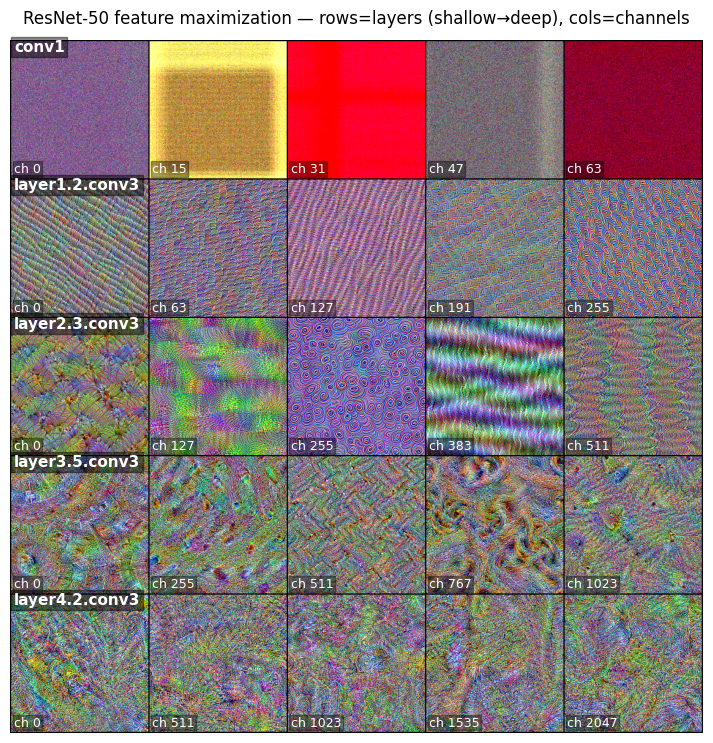

In [50]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image

# five distant layers (stage ends)
layers_5 = [
    "conv1",            # very early
    "layer1.2.conv3",   # end of stage 1
    "layer2.3.conv3",   # end of stage 2
    "layer3.5.conv3",   # end of stage 3
    "layer4.2.conv3",   # end of stage 4
]

# Per-layer hyperparams (deeper → a bit more steps/smoothness)
steps_for = {
    "conv1":          160,
    "layer1.2.conv3": 200,
    "layer2.3.conv3": 240,
    "layer3.5.conv3": 300,
    "layer4.2.conv3": 340,
}
grad_l2_for = {
    "conv1":          0.0,
    "layer1.2.conv3": 1e-5,
    "layer2.3.conv3": 2e-5,
    "layer3.5.conv3": 3e-5,
    "layer4.2.conv3": 5e-5,
}

# select channels
picked = {}
imgs = []
for L in layers_5:
    C = activation_channels(resnet, L)
    chs = evenly_spaced_channels(C, k=5)
    picked[L] = chs
    print(f"{L}: C={C}, channels={chs}")
    for c in chs:
        x = synthesize_channel_image_l2only(
            resnet, L, c,
            steps=steps_for.get(L, 240), lr=0.18,
            l2_w=3e-7, l1_w=0.0, grad_l2_w=grad_l2_for.get(L, 0.0),
            jitter=8, blur_every=0
        )
        imgs.append(denorm(x))

panel = make_grid(torch.cat(imgs, 0), nrow=5)


plt.figure(figsize=(12,9))
plt.imshow(panel.cpu().permute(1,2,0))
plt.axis("off")
plt.title("ResNet-50 feature maximization — rows=layers (shallow→deep), cols=channels", pad=12)


H, W = panel.shape[1], panel.shape[2]
rows_n, cols_n = 5, 5
row_h, col_w = H // rows_n, W // cols_n

# row labels (layer names)
for r, L in enumerate(layers_5):
    y = r*row_h + 18
    plt.text(6, y, L, color='white', fontsize=11, weight='bold',
             bbox=dict(facecolor='black', alpha=0.45, pad=2))

# per-cell channel labels
for r, L in enumerate(layers_5):
    for c, ch in enumerate(picked[L]):
        x = c*col_w + 6
        y = r*row_h + row_h - 10
        plt.text(x, y, f"ch {ch}", color='white', fontsize=9,
                 bbox=dict(facecolor='black', alpha=0.35, pad=1))

plt.show()


## 2(b) Residual Connection Anatomy

We compare three taps around a *non-projection* residual block (`layer2.1`):
1) **Origin** of the skip (the output of the previous block): `layer2.0`  
2) **Pre-add residual** (output of the residual branch just before the sum): `layer2.1.bn3`  
3) **Post-add (+ReLU) output** (block output after skip + residual): `layer2.1`

layer2.1 identity block: C=512, channels=[0, 127, 255, 383, 511]


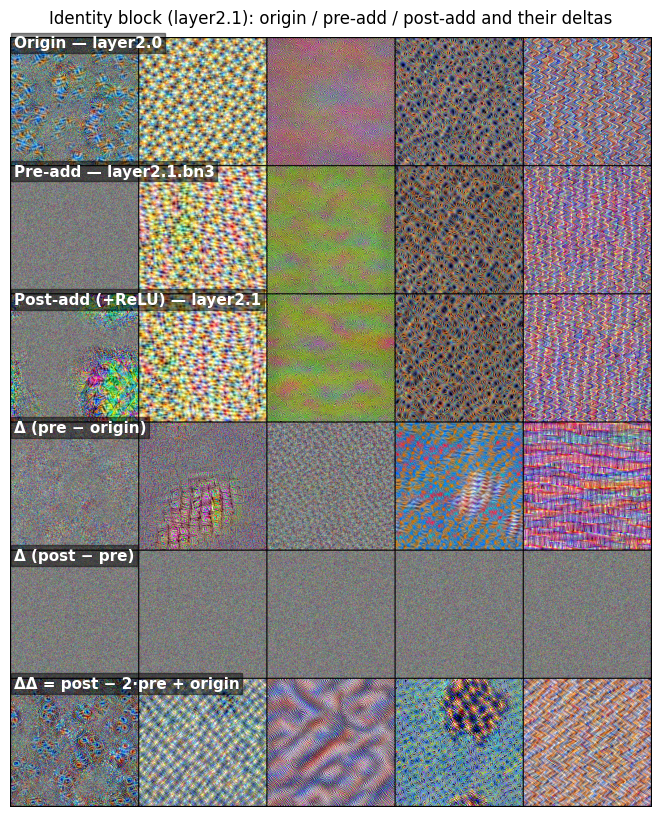

In [51]:
class IOHook:
    def __init__(self, layer, capture="output"):
        assert capture in ("output", "input")
        self.capture = capture
        self.h = layer.register_forward_hook(self._hook)
        self.act = None
    def _hook(self, m, inp, out):
        self.act = inp[0] if self.capture == "input" else out
    def close(self):
        self.h.remove()


def synthesize_linear_combo(
    model,
    taps,
    channel,
    weights,
    steps=260, lr=0.18,
    l2_w=3e-7, grad_l2_w=2e-5,
    jitter=8, seed=0, size=224
):
    assert len(taps) == len(weights) and len(taps) > 0


    layers   = [get_layer_by_name(model, name) for name, _ in taps]
    captures = [cap for _, cap in taps]

    hooks0 = [IOHook(layer, capture=cap) for layer, cap in zip(layers, captures)]
    with torch.no_grad():
        _ = model(torch.zeros(1,3,size,size, device=device))
        Cs = [h.act.shape[1] for h in hooks0]
    for h in hooks0: h.close()
    assert len(set(Cs)) == 1, f"Channel size mismatch across taps: {Cs}"
    C = Cs[0]
    assert 0 <= channel < C


    g = torch.Generator(device=device).manual_seed(seed)
    x = torch.randn(1,3,size,size, device=device, generator=g)*0.05
    x = (x - x.min())/(x.max()-x.min()+1e-8)
    x = (x - IMAGENET_MEAN.view(1,3,1,1)) / IMAGENET_STD.view(1,3,1,1)
    x.requires_grad_(True)

    hooks = [IOHook(layer, capture=cap) for layer, cap in zip(layers, captures)]
    opt = torch.optim.Adam([x], lr=lr)

    for _ in range(steps):
        opt.zero_grad()
        ox = 0 if jitter==0 else torch.randint(-jitter, jitter+1, (1,), device=device).item()
        oy = 0 if jitter==0 else torch.randint(-jitter, jitter+1, (1,), device=device).item()
        xj = torch.roll(torch.roll(x, ox, 3), oy, 2)

        model(xj)
        combo = 0.0
        for w, h in zip(weights, hooks):
            combo = combo + w * h.act[:, channel].mean()

        loss = -combo + l2_w*(x**2).mean()
        if grad_l2_w > 0:
            dx = denorm(x)[:,:,:,1:] - denorm(x)[:,:,:,:-1]
            dy = denorm(x)[:,:,1:,:] - denorm(x)[:,:,:-1,:]
            loss = loss + grad_l2_w*((dx**2).mean() + (dy**2).mean())

        loss.backward(); opt.step()
        with torch.no_grad():
            x.copy_(torch.roll(torch.roll(x, -ox, 3), -oy, 2))

    for h in hooks: h.close()
    return denorm(x.detach())


origin_tap = ("layer2.0",     "output")
pre_tap    = ("layer2.1.bn3", "output")
post_tap   = ("layer2.1",     "output")

tmp = IOHook(get_layer_by_name(resnet, pre_tap[0]), capture=pre_tap[1])
with torch.no_grad(): _ = resnet(torch.zeros(1,3,224,224, device=device))
C = tmp.act.shape[1]; tmp.close()
chs = evenly_spaced_channels(C, k=5)
print(f"layer2.1 identity block: C={C}, channels={chs}")

rows_imgs = []


for c in chs:
    rows_imgs.append(synthesize_linear_combo(resnet, [origin_tap], c, [1.0],
                    steps=240, grad_l2_w=2e-5))

for c in chs:
    rows_imgs.append(synthesize_linear_combo(resnet, [pre_tap], c, [1.0],
                    steps=240, grad_l2_w=2e-5))

for c in chs:
    rows_imgs.append(synthesize_linear_combo(resnet, [post_tap], c, [1.0],
                    steps=260, grad_l2_w=2e-5))

for c in chs:
    rows_imgs.append(synthesize_linear_combo(resnet, [pre_tap, origin_tap], c, [1.0, -1.0],
                    steps=280, grad_l2_w=3e-5))

for c in chs:
    rows_imgs.append(synthesize_linear_combo(resnet, [post_tap, pre_tap], c, [1.0, -1.0],
                    steps=300, grad_l2_w=3e-5))

for c in chs:
    rows_imgs.append(synthesize_linear_combo(resnet, [post_tap, pre_tap, origin_tap], c, [1.0, -2.0, 1.0],
                    steps=320, grad_l2_w=3e-5))

panel = make_grid(torch.cat(rows_imgs, 0), nrow=5)

plt.figure(figsize=(12,10))
plt.imshow(panel.cpu().permute(1,2,0)); plt.axis("off")
plt.title("Identity block (layer2.1): origin / pre-add / post-add and their deltas", pad=10)

# Row labels
H, W = panel.shape[1], panel.shape[2]
row_h, col_w = H // 6, W // 5
labels = [
    "Origin — layer2.0",
    "Pre-add — layer2.1.bn3",
    "Post-add (+ReLU) — layer2.1",
    "Δ (pre − origin)",
    "Δ (post − pre)",
    "ΔΔ = post − 2·pre + origin",
]
for r, lab in enumerate(labels):
    y = r*row_h + 18
    plt.text(6, y, lab, color='white', fontsize=11, weight='bold',
             bbox=dict(facecolor='black', alpha=0.45, pad=2))
plt.show()


## 2(c) Layer types at the same depth: conv vs identity block vs projection block

Goal: Compare learned features **controlling for depth** (same stage). We’ll visualize five channels from:

1) **Conv path only** — `layer3.1.bn3` (output of the residual branch before the skip is added)
2) **Identity block output** — `layer3.1` (post-add + ReLU; skip is identity)
3) **Projection block output** — `layer3.0` (post-add + ReLU; skip uses a 1×1 conv to project)

All of these are in **stage 3** (same spatial size and channel width).  



In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image


stage = 3

id_block = f"layer{stage}.1"   # identity block (skip is identity)
proj_block = f"layer{stage}.0" # projection block (skip uses conv)
conv_path = f"{id_block}.bn3"  # conv stack's final BN (pre-add)

class IOHook:
    def __init__(self, layer, capture="output"):
        assert capture in ("output","input")
        self.capture = capture
        self.h = layer.register_forward_hook(self._hook)
        self.act = None
    def _hook(self, m, inp, out):
        self.act = inp[0] if self.capture=="input" else out
    def close(self): self.h.remove()

hk = IOHook(get_layer_by_name(resnet, conv_path), capture="output")
with torch.no_grad():
    _ = resnet(torch.zeros(1,3,224,224, device=device))
C = hk.act.shape[1]; hk.close()

chs = evenly_spaced_channels(C, k=5)
print(f"Stage {stage}: C={C}, channels={chs}")
rows = [
    ("Conv path only — " + conv_path, conv_path, "output"),
    ("Identity block (post-add) — " + id_block, id_block, "output"),
    ("Projection block (post-add) — " + proj_block, proj_block, "output"),
]

# Slightly stronger smoothness for deeper stages
grad_l2 = {2:2e-5, 3:3e-5, 4:5e-5}.get(stage, 2e-5)
steps   = {2:240,  3:300,  4:340}.get(stage, 260)

imgs = []
for title, tap, capture in rows:
    print(title)
    for c in chs:
        if capture != "output":
            raise ValueError("In this cell we only use module outputs.")
        x = synthesize_channel_image_l2only(
            resnet, tap, c,
            steps=steps, lr=0.18,
            l2_w=3e-7, l1_w=0.0, grad_l2_w=grad_l2,
            jitter=8, blur_every=0,
            seed=SEED
        )
        imgs.append(denorm(x))

panel = make_grid(torch.cat(imgs,0), nrow=5)

plt.figure(figsize=(12,7))
plt.imshow(panel.cpu().permute(1,2,0)); plt.axis("off")
plt.title(f"Stage {stage}: conv path vs identity block vs projection block", pad=10)

H, W = panel.shape[1], panel.shape[2]
row_h, col_w = H // 3, W // 5
for r, (title, _, __) in enumerate(rows):
    y = r*row_h + 18
    plt.text(6, y, title, color='white', fontsize=11, weight='bold',
             bbox=dict(facecolor='black', alpha=0.45, pad=2))

for r in range(3):
    for c, ch in enumerate(chs):
        x = c*col_w + 6
        y = r*row_h + row_h - 10
        plt.text(x, y, f"ch {ch}", color='white', fontsize=9,
                 bbox=dict(facecolor='black', alpha=0.35, pad=1))
plt.show()


Stage 3: C=1024, channels=[0, 255, 511, 767, 1023]
Conv path only — layer3.1.bn3
